# **User Metrics & Behavioral Analysis for TravelTide**


## **Notebook Description**

**`user_metrics.ipynb`** provides a clear workflow to analyze **TravelTide users**, uncover behavioral patterns, and generate predictive metrics. It transforms raw user data into actionable insights for data-driven decisions.

**Key Highlights:**

* **Feature Engineering:** Extracts user-level features like session activity, booking trends, and engagement scores.
* **Behavioral Analysis:** Identifies patterns in user behavior and engagement across segments.
* **Predictive Metrics:** Calculates churn risk, lifetime value, and user segmentation to support retention and marketing strategies.
* **Visual Insights:** Clear charts and summaries highlight trends and high-value opportunities.



### **Environment Setup & Path Configuration**
* **Action:** The notebook begins by cleaning the system path (`sys.path`) to ensure no conflicting modules are loaded. It explicitly removes bad paths and adds the project root directory.
* **Purpose:** This ensures the custom `src` library can be imported correctly, which contains the essential `DataLoader`tools.

In [67]:
import sys, os  # noqa: E401

# --- Setup ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")
for p in sys.path:
    print(" -", p)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Clean sys.path:
 - /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
 - /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
 - /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
 - /opt/anaconda3/envs/ml311/lib/python311.zip
 - /opt/anaconda3/envs/ml311/lib/python3.11
 - /opt/anaconda3/envs/ml311/lib/python3.11/lib-dynload
 - 
 - /opt/anaconda3/envs/ml311/lib/python3.11/site-packages
 - __editable__.tts_mastery_project-0.1.0.finder.__path_hook__


## **Project Environment Setup & Core Module Verification**

This notebook sets up the Python environment by adding the project root to `sys.path` and importing essential libraries like `pandas` and `numpy`. It also verifies that the `src` module is accessible, ensuring the project environment is correctly configured for development and analysis.


In [68]:
import pandas as pd  # noqa: F401
import numpy as np  # noqa: F401
from IPython.display import display

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# - Works even if notebook is in a subfolder of notebooks/
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Project root = traveltide_project folder
# Assumes notebooks/ is directly under traveltide_project/
project_root = os.path.abspath(os.path.join(cwd, "..", ".."))
print("Project root:", project_root)

## ------------------------------------------------------------
# 2️⃣ Add project root to sys.path for imports
# ------------------------------------------------------------
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

print(sys.path)  # Ensure /traveltide_project is included

# Check if src exists
print(os.path.exists(os.path.join(project_root, "src")))


Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/notebooks/features
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
['/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project', '/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project', '/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project', '/opt/anaconda3/envs/ml311/lib/python311.zip', '/opt/anaconda3/envs/ml311/lib/python3.11', '/opt/anaconda3/envs/ml311/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/ml311/lib/python3.11/site-packages', '__editable__.tts_mastery_project-0.1.0.finder.__path_hook__']
True


In [69]:

# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")

✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/__init__.py


## **Data Loading, Session Cleaning, and User Feature Pipeline Setup**


This notebook imports core components for handling user data, including `DataLoader` for loading datasets, `SessionCleaner` for preprocessing session data, and `UserFeaturePipeline` for generating user-level features. It serves as the foundation for subsequent data analysis and feature engineering workflows.


In [70]:
from src.core import (
    DataLoader, # noqa: F401
    SessionCleaner,
    UserFeaturePipeline
) 

## **Load User and Session Data Using DataLoader**


This notebook section uses the `DataLoader` class to load key datasets for analysis. It loads:

1. **Raw user data** (`users` table).
2. **Cleaned session data** (`sessions_cleaned` table).
3. **Non-canceled session data** (`sessions_not_canceled_trips` table).




In [71]:
loader = DataLoader()
users = loader.load_table(data_type='raw', table_name='users')
sessions = loader.load_table(data_type='processed', table_name='sessions_cleaned')
nc_sessions = loader.load_table(data_type='processed', table_name='sessions_not_canceled_trips')

✅ Verbindung zur PostgreSQL-Datenbank hergestellt.
📁 Lade Tabelle 'users' aus CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/raw/users.csv
✅ CSV geladen. Zeilen: 1020926
📁 Lade Tabelle 'sessions_cleaned' aus CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/processed/sessions_cleaned.csv
✅ CSV geladen. Zeilen: 49211
📁 Lade Tabelle 'sessions_not_canceled_trips' aus CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/processed/sessions_not_canceled_trips.csv
✅ CSV geladen. Zeilen: 15489


/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/core/processing/load_data.py:88: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


## **Initialize User Feature Pipeline**

This notebook section initializes the `UserFeaturePipeline` with the loaded datasets:

* `sessions` – cleaned session data
* `nc_sessions` – non-canceled session data
* `users` – raw user data


In [72]:
user_feature_pipeline = UserFeaturePipeline(
    df_sessions=sessions,
    df_nc_sessions=nc_sessions,
    df_users=users,
)

## **Generate User Metrics**






This section runs the `UserFeaturePipeline` to compute user-level metrics.
The output, `user_metrics`, contains engineered features and behavioral metrics ready for analysis, visualization, and predictive modeling.

In [73]:
user_metrics = user_feature_pipeline.run()

🔧 Starting full user feature pipeline...
 Running behavior metrics...
--- Start: Calculating User Behavior Metrics ---
Preprocessing dates...
1/5: Enriching session data...
Enriching session data with window shopping and cancellation flags...
2/5: Aggregating session metrics...
Aggregating session metrics by user...
3/5: Enriching trip data (Types, Costs, Distance)...
Enriching trip data with derived features and costs...
⚠️ Warning: 'destination_country' or 'home_country' column missing. 'is_international' set to NaN.
4/5: Aggregating trip metrics...
Aggregating trip metrics by user...


/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/core/features/user_behavior_metrics.py:266: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  growth_df = self.df_nc_sessions.groupby('user_id').apply(compute_growth).reset_index(name='booking_growth')


5/5: Finalizing user table and saving...
Merging user data and deriving features (Age, Persona)...
✅ User base saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/processed/features/user_behavior_metrics.csv
Rows: 5998, Columns: 40
--- End: User Behavior Metrics Pipeline Completed ---
Behavior metrics complete: shape=(5998, 40)


,user_id,num_clicks,avg_session_clicks,max_session_clicks,num_empty_sessions,num_canceled_trips,num_sessions,avg_session_duration,num_trips,num_destinations,...,num_season_winter,booking_growth,gender,married,has_children,home_country,home_city,age,global_booking_share,persona_type
0,23557,82,10.250,32,6,0,8,78.166667,2.0,0.0,...,0.0,0.0,F,True,False,usa,new york,67.019178,0.000129,Solo
1,94883,73,9.125,27,6,0,8,31.000000,2.0,2.0,...,0.0,0.0,F,True,False,usa,kansas city,53.739726,0.000129,Solo
2,101486,131,16.375,24,6,0,8,110.500000,2.0,1.0,...,0.0,0.0,F,True,True,usa,tacoma,53.010959,0.000129,Family
3,101961,126,15.750,25,3,0,8,55.333333,5.0,5.0,...,1.0,0.0,F,True,False,usa,boston,45.235616,0.000323,Business
4,106907,240,30.000,81,6,2,8,93.000000,0.0,0.0,...,0.0,0.0,F,True,True,usa,miami,47.063014,0.000000,Family


 Running advanced metrics...
--- Start: Calculating Advanced User Metrics ---
1/6: Fetching hotel coordinates and computing distances...
📂 Loading existing hotel coordinates from /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/processed/feature/hotel_to_coordinates.csv
2/6: Computing discount metrics...
  Discount metrics shape: (5442, 3)
3/6: Computing browsing behavior metrics...
  Browsing metrics shape: (5993, 6)
4/6: Computing RFM metrics...
   RFM metrics shape: (5442, 2)
6/6: Computing sustainable travel metrics...
  Sustainable metrics shape: (1960, 2)
 Merging all advanced metrics...
  Final merged shape: (5998, 10)
--- End: Advanced User Metrics Pipeline Completed ---
✅ Advanced metrics complete: 10 features for 5998 users
Advanced metrics complete: raw_shape=(5998, 10)


,user_id,avg_dollars_saved_per_km,bargain_hunter_index,num_browsing_sessions,avg_browsing_duration,total_browsing_clicks,browsing_intensity,conversion_rate,RFM_score,sustainable_index
0,23557,NaN,NaN,6.0,78.166667,63.0,10.500000,0.250,4.0,0.5
1,94883,NaN,NaN,6.0,31.000000,25.0,4.166667,0.250,1.0,NaN
2,101486,NaN,NaN,6.0,110.500000,89.0,14.833333,0.250,3.0,0.0
3,101961,0.016548,0.001655,3.0,55.333333,22.0,7.333333,0.625,8.0,NaN
4,106907,NaN,NaN,6.0,93.000000,136.0,22.666667,0.250,NaN,NaN


 Merging behavior and advanced metrics...
Merged dataset shape=(5998, 49)


,user_id,num_clicks,avg_session_clicks,max_session_clicks,num_empty_sessions,num_canceled_trips,num_sessions,avg_session_duration,num_trips,num_destinations,...,persona_type,avg_dollars_saved_per_km,bargain_hunter_index,num_browsing_sessions,avg_browsing_duration,total_browsing_clicks,browsing_intensity,conversion_rate,RFM_score,sustainable_index
0,23557,82,10.250,32,6,0,8,78.166667,2.0,0.0,...,Solo,NaN,NaN,6.0,78.166667,63.0,10.500000,0.250,4.0,0.5
1,94883,73,9.125,27,6,0,8,31.000000,2.0,2.0,...,Solo,NaN,NaN,6.0,31.000000,25.0,4.166667,0.250,1.0,NaN
2,101486,131,16.375,24,6,0,8,110.500000,2.0,1.0,...,Family,NaN,NaN,6.0,110.500000,89.0,14.833333,0.250,3.0,0.0
3,101961,126,15.750,25,3,0,8,55.333333,5.0,5.0,...,Business,0.016548,0.001655,3.0,55.333333,22.0,7.333333,0.625,8.0,NaN
4,106907,240,30.000,81,6,2,8,93.000000,0.0,0.0,...,Family,NaN,NaN,6.0,93.000000,136.0,22.666667,0.250,NaN,NaN


 Combined feature set saved: 54 features for 5998 users


In [74]:
print(user_metrics.columns)

Index(['user_id', 'num_clicks', 'avg_session_clicks', 'max_session_clicks',
       'num_empty_sessions', 'num_canceled_trips', 'num_sessions',
       'avg_session_duration', 'num_trips', 'num_destinations', 'num_flights',
       'num_hotels', 'num_group_trips', 'num_pair_trips', 'num_business_trips',
       'num_weekend_trips_agg', 'num_discount_trips_agg',
       'money_spent_hotel_total', 'avg_money_spent_flight',
       'avg_money_spent_hotel_trip', 'avg_money_spent_per_seat',
       'avg_km_flown', 'avg_bags', 'international_ratio',
       'avg_time_after_booking', 'avg_trip_length', 'num_season_fall',
       'num_season_spring', 'num_season_summer', 'num_season_unknown',
       'num_season_winter', 'booking_growth', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'age',
       'global_booking_share', 'persona_type', 'avg_dollars_saved_per_km',
       'bargain_hunter_index', 'num_browsing_sessions',
       'avg_browsing_duration', 'total_browsing_clicks', '

In [75]:
categorical_cols = user_metrics.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("🟪 Categorical columns detected (object, category, bool):")
display(pd.DataFrame({'categorical_columns': categorical_cols}))

🟪 Categorical columns detected (object, category, bool):


,categorical_columns
0,gender
1,married
2,has_children
3,home_country
4,home_city
5,persona_type


## ** Missing Values Summary**

[INFO] Missingness diagram saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/loader/missing_values_avg.png


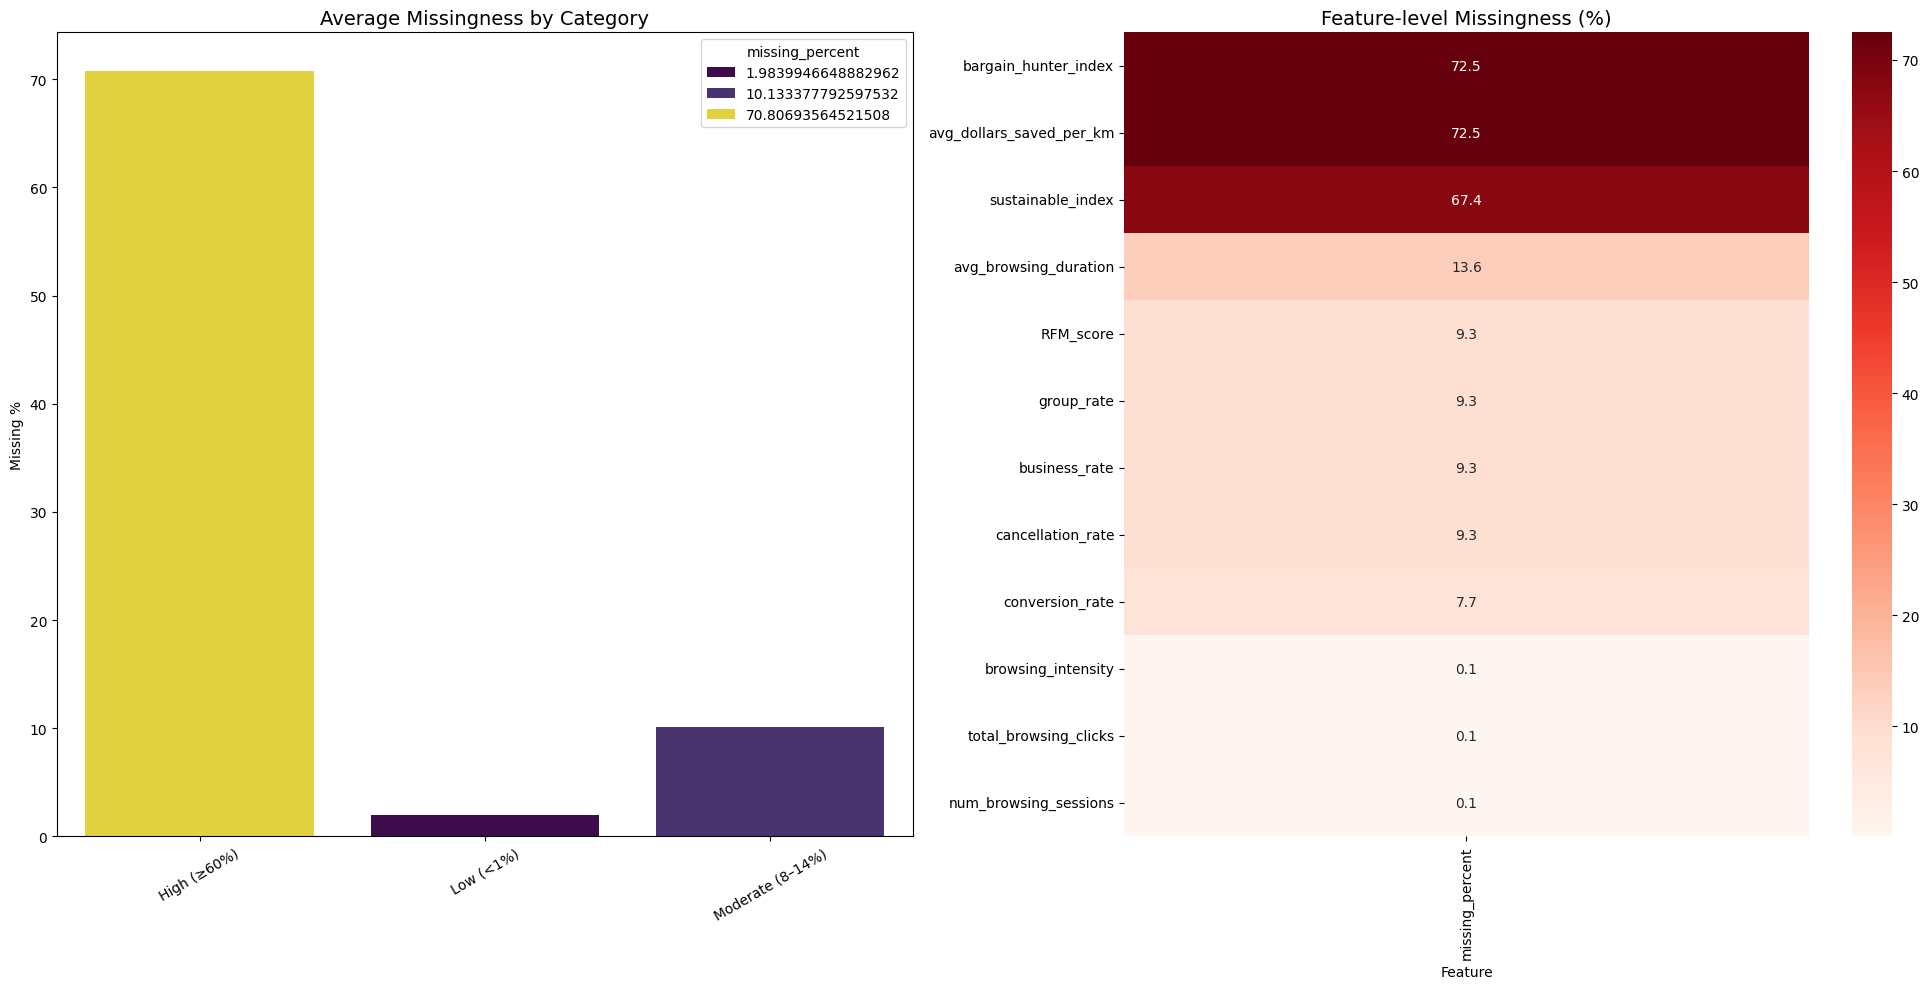

In [76]:
loader.plot_missingness_combined(user_metrics)

## Display statistic

In [77]:
cleaner = SessionCleaner(verbosity=3)

stats=cleaner.describe_columns(user_metrics)

SessionCleaner initialized with verbosity=3
Output directory resolved to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/cleaner

Generating descriptive statistics for columns: ['num_clicks', 'avg_session_clicks', 'max_session_clicks', 'num_empty_sessions', 'num_canceled_trips', 'num_sessions', 'avg_session_duration', 'num_trips', 'num_destinations', 'num_flights', 'num_hotels', 'num_group_trips', 'num_pair_trips', 'num_business_trips', 'num_weekend_trips_agg', 'num_discount_trips_agg', 'money_spent_hotel_total', 'avg_money_spent_flight', 'avg_money_spent_hotel_trip', 'avg_money_spent_per_seat', 'avg_km_flown', 'avg_bags', 'international_ratio', 'avg_time_after_booking', 'avg_trip_length', 'num_season_fall', 'num_season_spring', 'num_season_summer', 'num_season_unknown', 'num_season_winter', 'booking_growth', 'age', 'global_booking_share', 'avg_dollars_saved_per_km', 'bargain_hunter_index', 'num_browsing_sessions', 'avg_browsing_duration', 'tot

,count,mean,std,min,25%,50%,75%,max
num_clicks,5998.0,144.308436,72.330165,33.000000,102.000000,127.000000,161.000000,873.000000
avg_session_clicks,5998.0,17.586393,8.735165,4.125000,12.500000,15.625000,19.625000,109.125000
max_session_clicks,5998.0,47.600867,41.814686,6.000000,26.000000,34.000000,48.000000,566.000000
num_empty_sessions,5998.0,5.419973,1.611049,0.000000,4.000000,5.000000,7.000000,12.000000
num_canceled_trips,5998.0,0.202234,0.617364,0.000000,0.000000,0.000000,0.000000,4.000000
num_sessions,5998.0,8.204568,0.460911,8.000000,8.000000,8.000000,8.000000,12.000000
avg_session_duration,5998.0,75.243774,58.319872,0.000000,48.425000,71.666667,98.364583,1367.000000
num_trips,5998.0,2.582361,1.533290,0.000000,1.000000,3.000000,4.000000,8.000000
num_destinations,5998.0,2.078693,1.422845,0.000000,1.000000,2.000000,3.000000,7.000000
num_flights,5998.0,4.291097,2.986260,0.000000,2.000000,4.000000,6.000000,16.000000



- **Engagement metrics (clicks, sessions, browsing rate, conversion rate)**  
  These show how actively users interact with the platform and whether they convert. High engagement but low conversion highlights users who need **extra incentives** — perks can be the nudge that turns browsing into booking.

- **Trip behavior (num_trips, destinations, flights, hotels, trip length, km flown)**  
  These reveal travel intensity and style. Frequent travelers versus occasional weekenders have different needs. Segmentation ensures perks are matched to travel frequency and trip type, maximizing relevance.

- **Spending metrics (hotel spend, flight spend, total spend, discount usage)**  
  Spending distribution identifies **budget-conscious vs. premium customers**. Perks can be allocated to reward loyalty at both ends: discounts for value seekers, exclusive perks for high spenders.

- **Seasonality (spring/winter peaks, summer/fall lows)**  
  Seasonal travel patterns guide **timing of perk distribution**. Offering perks during peak seasons boosts competitiveness, while off‑season perks stimulate demand.

- **Demographics & RFM scores (age, business/group rates, RFM value)**  
  These highlight **customer lifetime value** and special niches (business travelers, group trips). Perks can reinforce loyalty among high‑value users and encourage underrepresented segments.

---

## Fazit: Why Perks Distribution Should Be Driven by Metrics
- **“1 night free hotel with flight”** → Important because trip length and hotel spend metrics show most trips are short (3–4 days, 2–3 hotels). This perk directly enhances short‑trip value and increases bundled bookings.  
- **“Free hotel meal”** → Spending and discount metrics reveal strong price sensitivity (50% book discounted trips). This perk adds perceived value without lowering headline prices.  
- **“Free checked bag”** → Flight frequency metrics (avg 4–6 flights) show many users are repeat flyers. This perk reduces friction and builds loyalty among frequent travelers.  
- **“No cancellation fees”** → Browsing and session duration metrics show long planners and business travelers need flexibility. This perk builds trust and reduces booking hesitation.  
- **“Exclusive discounts”** → With half of users booking discounted trips and browsing rates at 66%, this perk is critical to convert high engagement into actual bookings.
